In [5]:
import polars as pl

In [76]:
train = "/home/work/data/GUIDE/GUIDE_Train.csv"
excel_file = "/home/work/notebook/GUIDE/technique.xlsx"

In [136]:
df = pl.read_csv(train)

In [8]:
df.head()

Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
i64,i64,i64,i64,str,i64,i64,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,str,str,i64,i64,str,str,str,i64,i64,i64
180388628218,0,612,123247,"""2024-06-04T06:…",7,6,"""InitialAccess""",null,"""TruePositive""",null,null,"""Ip""","""Related""",98799,138268,27,160396,441377,673934,425863,453297,153085,529644,null,1631,635,860,2251,3421,881,null,289573,117668,3586,null,null,5,66,null,null,null,31,6,3
455266534868,88,326,210035,"""2024-06-14T03:…",58,43,"""Exfiltration""",null,"""FalsePositive""",null,null,"""User""","""Impacted""",98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,null,1631,635,860,2251,3421,881,null,289573,117668,3586,null,null,5,66,null,null,null,242,1445,10630
1056561957389,809,58352,712507,"""2024-06-13T04:…",423,298,"""InitialAccess""","""T1189""","""FalsePositive""",null,null,"""Url""","""Related""",98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,null,1631,635,860,2251,3421,881,null,289573,117668,3586,null,null,5,66,null,"""Suspicious""","""Suspicious""",242,1445,10630
1279900258736,92,32992,774301,"""2024-06-10T16:…",2,2,"""CommandAndCont…",null,"""BenignPositive…",null,null,"""Url""","""Related""",98799,138268,360606,13,441377,673934,425863,453297,153085,529644,null,1631,635,860,2251,3421,881,null,289573,117668,3586,null,null,5,66,null,"""Suspicious""","""Suspicious""",242,1445,10630
214748368522,148,4359,188041,"""2024-06-15T01:…",9,74,"""Execution""",null,"""TruePositive""",null,null,"""User""","""Impacted""",98799,138268,360606,160396,449,592,440,479,153085,529644,null,1631,635,860,2251,3421,881,null,289573,117668,3586,null,null,5,66,null,null,null,242,1445,10630


In [166]:
df.get_column("IncidentId").unique().shape[0]

466151

In [137]:
mitre_df = df.drop_nulls(subset="MitreTechniques")

In [138]:
mitre_df.shape

(4048451, 45)

## インシデント全体

In [139]:
import matplotlib.pyplot as plt

In [140]:
counted_df = mitre_df.groupby(pl.col("IncidentId")).count().sort("count")
incident_sizes = counted_df.filter(pl.col("count") <= 100).sort("count").get_column("count").to_numpy()

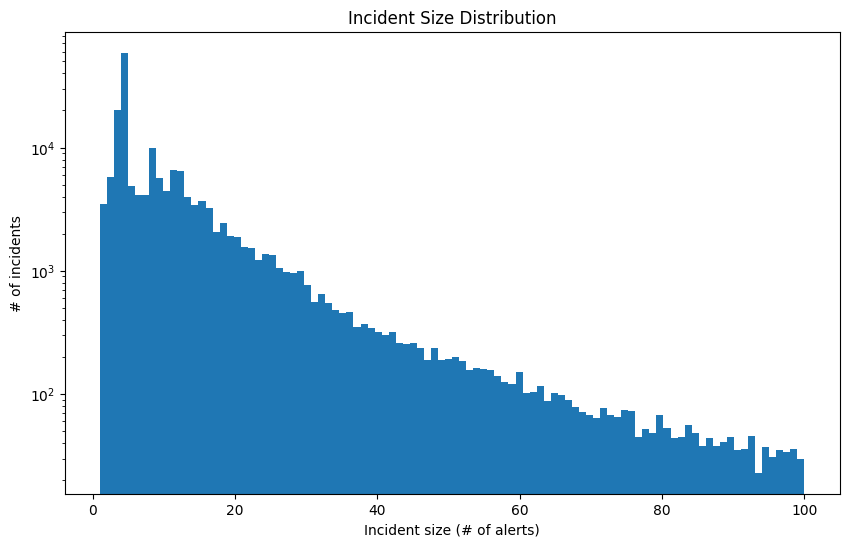

In [141]:
# 散布図の描画
plt.figure(figsize=(10, 6))
plt.hist(incident_sizes, bins=100, log=True)
plt.yscale('log')
plt.title('Incident Size Distribution')
plt.xlabel('Incident size (# of alerts)')
plt.ylabel('# of incidents')
plt.show()

## Preparation タスク

In [142]:
excel_df = pl.read_excel(excel_file)

In [143]:
preparation = ["Reconnaissance", "Resource Development", "Initial Access"]
intrusion = ['Defense Evasion', 'Discovery', 'Collection', 'Lateral Movement', 'Execution', 'Credential Access', 'Command and Control', 'Privilege Escalation', 'Persistence']
compromize = ["Impact", "Exfiltration"]

In [144]:
excel_df = excel_df.with_columns(pl.col("tactics").apply(lambda x: any(p in x for p in preparation )).alias('contains_preparation'))
excel_df = excel_df.with_columns(pl.col("tactics").apply(lambda x: any(p in x for p in compromize )).alias('contains_compromize'))

In [145]:
preparation_dict = dict(zip(excel_df.get_column('ID').to_list(), excel_df.get_column('contains_preparation').to_list()))
compromize_dict = dict(zip(excel_df.get_column('ID').to_list(), excel_df.get_column('contains_compromize').to_list()))

In [146]:
def check_contains_preparation(techniques, preparation_dict):
    # mitreTechniques を ';' で分割してリスト化
    techniques_list = techniques.split(';')
    # それぞれのテクニックが辞書にあり、かつTrueであればTrueを返す
    return any(preparation_dict.get(technique, False) for technique in techniques_list)

In [147]:
mitre_df = mitre_df.with_columns(
    pl.col('MitreTechniques').apply(lambda x: check_contains_preparation(x, preparation_dict)).alias('is_preparation_alert')
)
mitre_df = mitre_df.with_columns(
    pl.col('MitreTechniques').apply(lambda x: check_contains_preparation(x, compromize_dict)).alias('is_compromize_alert')
)

## 

In [148]:
mitre_df.head()

Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,is_preparation_alert,is_compromize_alert
i64,i64,i64,i64,str,i64,i64,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,str,str,i64,i64,str,str,str,i64,i64,i64,bool,bool
1056561957389,809,58352,712507,"""2024-06-13T04:…",423,298,"""InitialAccess""","""T1189""","""FalsePositive""",null,null,"""Url""","""Related""",98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,null,1631,635,860,2251,3421,881,null,289573,117668,3586,null,null,5,66,null,"""Suspicious""","""Suspicious""",242,1445,10630,true,false
1322849927433,11,417400,825450,"""2024-06-10T13:…",0,0,"""InitialAccess""","""T1078;T1078.00…","""FalsePositive""",null,null,"""Ip""","""Related""",98799,138268,30410,160396,441377,673934,425863,453297,153085,529644,null,1631,635,860,2251,3421,881,null,289573,117668,3586,null,null,5,66,null,null,null,8,6,3,true,false
781684051738,2119,6622,23284,"""2024-06-10T10:…",13,11,"""InitialAccess""","""T1566""","""BenignPositive…",null,null,"""MailMessage""","""Related""",98799,138268,360606,160396,441377,160691,425863,453297,153085,1842,null,1631,635,860,2251,3421,881,null,289573,117668,3586,null,null,5,66,null,null,null,242,1445,10630,true,false
635655163305,261,110412,41503,"""2024-06-03T17:…",1794,344,"""Collection""","""T1098;T1114""","""BenignPositive…",null,null,"""User""","""Impacted""",98799,138268,360606,160396,172996,268738,173595,184537,153085,529644,null,1631,635,860,2251,3421,881,null,289573,117668,3586,null,null,5,66,null,null,null,242,1445,10630,false,false
429496732853,51,84683,134887,"""2024-06-05T04:…",39,26,"""Execution""","""T1559;T1106;T1…","""BenignPositive…",null,null,"""File""","""Related""",98799,4,360606,160396,441377,673934,425863,453297,153085,529644,null,1631,635,860,2251,3421,881,null,3,6,3586,null,null,5,66,null,null,null,242,1445,10630,false,false


In [149]:
mitre_df.shape

(4048451, 47)

In [157]:
incident_df = mitre_df.groupby("IncidentId").agg([pl.col("is_preparation_alert").sum(), pl.col("is_compromize_alert").sum(), pl.col("City").count().alias("alertsize")])

In [168]:
incident_df.shape[0]

183052

In [171]:
print(incident_df.filter(pl.col("is_preparation_alert") >= 1).shape)
print(incident_df.filter((pl.col("is_compromize_alert") >= 1) & pl.col("is_preparation_alert") >= 1).shape)

(158874, 4)
(2117, 4)


# 
トレインデータに含まれるシナリオは466,151個
そのうち、MITRE Techniqueが一つでも含まれる攻撃シナリオは183,052個
そのうち、ImpactもしくはExfiltrationが一つでも含まれる攻撃シナリオは  8,098個
そのうち、preparation_フェーズの攻撃が含まれる攻撃シナリオは 2117個